In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc, make_scorer, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from data_utils import load_metadata, sample_sounds_by_category, load_wave_data, load_all_sounds,load_paths_from_config
from feature_utils import combine_features_with_flags, test_feature_combinations_svm, test_feature_combinations_rf, compute_features_for_wave_list
from feature_utils import compute_combined_features_for_wave_list, save_features_to_npz, save_multiple_features_to_npz

In [2]:
csv_file_path, audio_files_path = load_paths_from_config()


# 1.1) check if the paths exist
assert os.path.exists(csv_file_path), "CSV file not found!"
assert os.path.exists(audio_files_path), "Audio directory not found!"


In [3]:
    # 2) Load metadata
    df = load_metadata(csv_file_path)

    print(df)
    print("Missing values:\n", df.isnull().sum()) # Check for missing values
    print(df.describe()) # Show summary statistics

               filename  fold  target        category  esc10  src_file take
0      1-100032-A-0.wav     1       0             dog   True    100032    A
1     1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2     1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3     1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4     1-101296-A-19.wav     1      19    thunderstorm  False    101296    A
...                 ...   ...     ...             ...    ...       ...  ...
1995   5-263831-B-6.wav     5       6             hen  False    263831    B
1996  5-263902-A-36.wav     5      36  vacuum_cleaner  False    263902    A
1997   5-51149-A-25.wav     5      25       footsteps  False     51149    A
1998    5-61635-A-8.wav     5       8           sheep  False     61635    A
1999     5-9032-A-0.wav     5       0             dog   True      9032    A

[2000 rows x 7 columns]
Missing values:
 filename    0
fold        0
target      0
cate

Class counts for selected categories:
 category
dog               40
vacuum_cleaner    40
thunderstorm      40
pouring_water     40
clock_alarm       40
helicopter        40
snoring           40
sneezing          40
rooster           40
siren             40
Name: count, dtype: int64
✅ All classes have 40 rows.


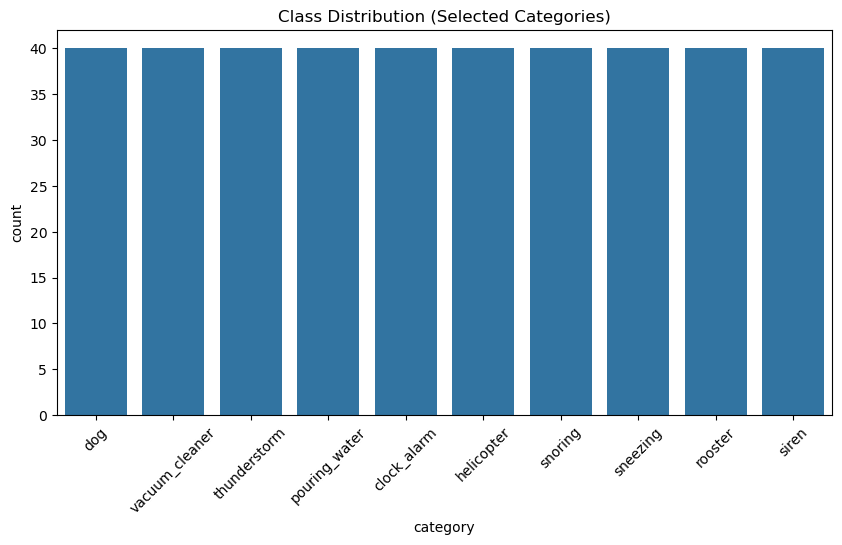

In [4]:
# 3) Define categories
categories = {
        'Animals': ['dog', 'rooster'],
        'Natural soundscapes & water sounds': ['thunderstorm', 'pouring_water'],
        'Human sounds': ['snoring', 'sneezing'],
        'Interior/domestic sounds': ['clock_alarm', 'vacuum_cleaner'],
        'Exterior/urban noises': ['siren', 'helicopter']
    }
# Filter the dataframe to only include selected categories
selected_classes = sum(categories.values(), [])  # Flatten the dictionary into a list of class names
df_filtered = df[df['category'].isin(selected_classes)]  # Keep only selected categories


class_counts = df_filtered['category'].value_counts()
print("Class counts for selected categories:\n", class_counts)
if all(class_counts == 40):
    print("✅ All classes have 40 rows.")
else:
    print("❌ Some classes do not have 40 rows.")
    print("Classes with insufficient rows:\n", class_counts[class_counts != 40])

# Plot class distribution of selected categories
plt.figure(figsize=(10, 5))
sns.countplot(x=df_filtered['category'])
plt.xticks(rotation=45)
plt.title("Class Distribution (Selected Categories)")
plt.show()



In [5]:
# Create a mapping dictionary from category to its target number
category_to_target = dict(zip(df_filtered['category'], df_filtered['target']))

# Print the dictionary
print("Category to Target Mapping:\n", category_to_target)

Category to Target Mapping:
 {'dog': 0, 'vacuum_cleaner': 36, 'thunderstorm': 19, 'pouring_water': 17, 'clock_alarm': 37, 'helicopter': 40, 'snoring': 28, 'sneezing': 21, 'rooster': 1, 'siren': 42}


In [6]:
# 4) Sample sounds
sampled_sounds = sample_sounds_by_category(df, categories)

# Track missing and represented classes
missing_classes = {}
represented_classes = {}

for category, expected_classes in categories.items():
    # Extract actual classes from sampled sounds
    sampled_classes = set(df[df['filename'].isin(sampled_sounds[category])]['category'])
    
    # Check which classes are missing
    missing = set(expected_classes) - sampled_classes
    represented_classes[category] = sampled_classes

    if missing:
        missing_classes[category] = missing

    print(f"Category: {category}, Sampled Classes: {sampled_classes}")

# Summary
print("\n✅ Represented Classes:")
for category, classes in represented_classes.items():
    print(f"- {category}: {classes}")

if missing_classes:
    print("\n❌ Missing Classes:")
    for category, classes in missing_classes.items():
        print(f"- {category}: {classes}")
else:
    print("\n🎉 All expected classes are present!")


Category: Animals, Sampled Classes: {'rooster', 'dog'}
Category: Natural soundscapes & water sounds, Sampled Classes: {'pouring_water', 'thunderstorm'}
Category: Human sounds, Sampled Classes: {'snoring', 'sneezing'}
Category: Interior/domestic sounds, Sampled Classes: {'clock_alarm', 'vacuum_cleaner'}
Category: Exterior/urban noises, Sampled Classes: {'helicopter', 'siren'}

✅ Represented Classes:
- Animals: {'rooster', 'dog'}
- Natural soundscapes & water sounds: {'pouring_water', 'thunderstorm'}
- Human sounds: {'snoring', 'sneezing'}
- Interior/domestic sounds: {'clock_alarm', 'vacuum_cleaner'}
- Exterior/urban noises: {'helicopter', 'siren'}

🎉 All expected classes are present!


In [7]:
# 5) Load wave data
wave_list_data_sampled = load_wave_data(sampled_sounds, audio_files_path) #load_sample
wave_list_data = load_all_sounds(df, categories, audio_files_path) #load all sounds

print("Total samples loaded:", len(wave_list_data))
print("Example sample rate:", wave_list_data[0][2])
print("Example waveform shape:", wave_list_data[0][3].shape)

Total samples loaded: 400
Example sample rate: 44100
Example waveform shape: (220500,)


In [8]:
# 7) Extract all features
# keys_list, combined_features = compute_combined_features_for_wave_list(wave_list_data)

In [9]:
# # 8) Save all features
# save_features_to_npz(keys_list, combined_features, out_file="features/extracted_features_combined.npz")

# # Check file integrity after saving
# loaded_data = np.load("features/extracted_features_combined.npz")
# print("Loaded feature shape:", loaded_data['features'].shape)
# print("Keys shape:", loaded_data['keys'].shape)

In [10]:
# 7) Extract selected features
keys_list, mfcc_list, hist_list, spectral_list, zcr_list, envelope_list, hnr_list = compute_features_for_wave_list(wave_list_data)

# 8) Save selected features
save_multiple_features_to_npz(
    keys_list, 
    mfcc_list, 
    hist_list, 
    spectral_list, 
    zcr_list, 
    envelope_list, 
    hnr_list, 
    out_file="features/extracted_features_multiple_test.npz"
)

Multiple features saved to features/extracted_features_multiple_test.npz


In [11]:
# Load saved features
loaded_data = np.load("features/extracted_features_multiple_test.npz")

# Define which features to include (set True to include, False to exclude)
feature_selection = {
    'mfcc': True,
    'hist': True,
    'spectral': True,
    'zcr': True,
    'envelope': True,
    'hnr': True
}

# Display the shapes of each feature type
print("Feature shapes and selection status:")
for feature, include in feature_selection.items():
    shape = loaded_data[feature].shape
    status = "✅" if include else "❌"
    print(f"{feature.capitalize()} shape: {shape} - Status: {status}")

# Extract features and labels
keys_list = loaded_data['keys']
mfcc_features = loaded_data['mfcc']
hist_features = loaded_data['hist']
spectral_features = loaded_data['spectral']
zcr_features = loaded_data['zcr']
envelope_features = loaded_data['envelope']
hnr_features = loaded_data['hnr']

# Display first feature vectors for verification
# print("First MFCC feature vector:", loaded_data['mfcc'][0])
# print("First histogram feature vector:", loaded_data['hist'][0])
# print("First spectral feature vector:", loaded_data['spectral'][0])
# print("First ZCR feature vector:", loaded_data['zcr'][0])
# print("First Amplitude Envelope feature vector:", loaded_data['envelope'][0])
# print("First HNR feature vector:", loaded_data['hnr'][0])

# Combine features based on flags
combined_features = combine_features_with_flags(loaded_data, feature_selection)
print("\nCombined features shape:", combined_features.shape)

Feature shapes and selection status:
Mfcc shape: (400, 26) - Status: ✅
Hist shape: (400, 80) - Status: ✅
Spectral shape: (400, 20) - Status: ✅
Zcr shape: (400, 2) - Status: ✅
Envelope shape: (400, 5) - Status: ✅
Hnr shape: (400, 1) - Status: ✅

Combined features shape: (400, 134)


/var/folders/mj/tvn3vfr55f56l2_qx4xbdnp00000gn/T/ipykernel_51994/2109124173.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_features["label"] = df_features["label"]  # Re-add labels


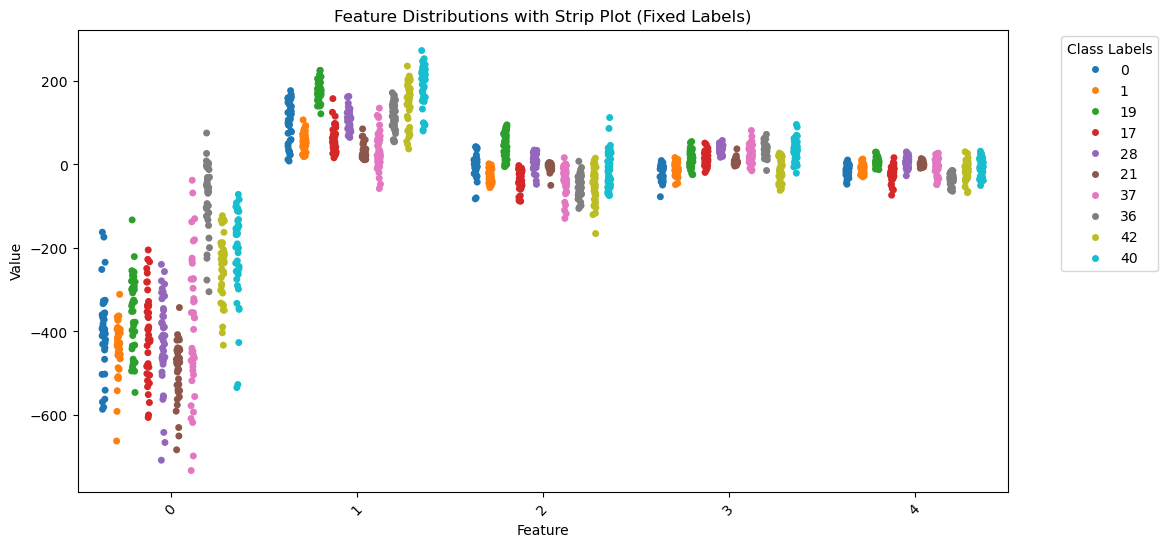

In [12]:
### Compare feature distributions for different classes

# Convert combined_features to DataFrame
df_features = pd.DataFrame(combined_features)
df_features["label"] = keys_list  # Add class labels

# Ensure labels are categorical, not just numbers
df_features["label"] = df_features["label"].astype(str)  # Convert to string labels

# Select first 5 features for visualization (modify if needed)
selected_features = df_features.iloc[:, :5]  
selected_features["label"] = df_features["label"]  # Re-add labels

# Convert to long format for plotting
df_melted = selected_features.melt(id_vars="label", var_name="Feature", value_name="Value")

# --- Strip Plot Fix ---
plt.figure(figsize=(12, 6))
sns.stripplot(x="Feature", y="Value", hue="label", data=df_melted, dodge=True, jitter=True)
plt.title("Feature Distributions with Strip Plot (Fixed Labels)")
plt.xticks(rotation=45)
plt.legend(title="Class Labels", bbox_to_anchor=(1.05, 1), loc='upper left')  # Fix legend
plt.show()



In [13]:
# Train-Test Splitting
X = combined_features
y = np.array(keys_list)

# Train-test split
X_train_not_scaled, X_test_not_scaled, y_train, y_test = train_test_split(
    combined_features, np.array(keys_list), test_size=0.2, random_state=42, stratify=keys_list
)


In [14]:
# Normalize the data using Z-score normalization (StandardScaler)
scaler = StandardScaler()


# feature normalization:
# feature = feature - mean(feature acrocss all examples) / std(feature across all examples)
## VERY IMPORTANT: the above mean and std must be calcualted from TRAIN data only, not from EVAL or TEST data

# Fit only on the training data and transform both train and test sets
X_train = scaler.fit_transform(X_train_not_scaled)  # Fit on train data only
X_test = scaler.transform(X_test_not_scaled)        # Use train's mean and std to scale test data

In [15]:
# Print sizes of train and test sets
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

# Debugging - Check which classes exist before and after splitting
unique_classes = set(keys_list)
print("Unique classes in dataset before splitting:", unique_classes)

# Count occurrences of each class in train and test sets
train_counts = pd.Series(y_train).value_counts().sort_index()
test_counts = pd.Series(y_test).value_counts().sort_index()

# Print class counts for debugging purposes
print("\nTraining Class Counts:\n", train_counts)
print("\nTest Class Counts:\n", test_counts)

Training set size: (320, 134)
Test set size: (80, 134)
Unique classes in dataset before splitting: {0, 1, 36, 37, 40, 42, 17, 19, 21, 28}

Training Class Counts:
 0     32
1     32
17    32
19    32
21    32
28    32
36    32
37    32
40    32
42    32
Name: count, dtype: int64

Test Class Counts:
 0     8
1     8
17    8
19    8
21    8
28    8
36    8
37    8
40    8
42    8
Name: count, dtype: int64


In [16]:
# Convert lists to Pandas Series for counting
train_counts = pd.Series(y_train).value_counts()
test_counts = pd.Series(y_test).value_counts()

# Merge train and test counts into a single DataFrame
df_counts = pd.DataFrame({'Train': train_counts, 'Test': test_counts}).fillna(0).astype(int)

# Plot bar chart for class distributions
# df_counts.plot(kind="bar", figsize=(10, 5), color=["blue", "red"], alpha=0.7)
# plt.xlabel("Class Labels")
# plt.ylabel("Count")
# plt.title("Train vs Test Class Distribution (Selected Classes Only)")
# plt.xticks(rotation=45)
# plt.legend(title="Dataset")
# plt.show()


# Display the counts table with a better format
print("\nClass Distribution Table:")
print(df_counts.to_string())

# Display summary
print("\nSummary:")
print(f"Total samples in Train set: {df_counts['Train'].sum()}")
print(f"Total samples in Test set: {df_counts['Test'].sum()}")



Class Distribution Table:
    Train  Test
0      32     8
1      32     8
17     32     8
19     32     8
21     32     8
28     32     8
36     32     8
37     32     8
40     32     8
42     32     8

Summary:
Total samples in Train set: 320
Total samples in Test set: 80


In [17]:
# # Define Stratified K-Fold
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # Define hyperparameter grid
# param_grid = {
#     'C': [0.01, 0.1, 1``, 10, 100],  # Reasonable range of C values
#     'gamma': [0.01, 0.1, 1, 'scale', 10, 100],  # Includes 'scale'
#     'kernel': ['rbf']  # Using only RBF kernel
# }

# # Perform GridSearch with Stratified K-Fold
# grid_search = GridSearchCV(SVC(), param_grid, cv=kfold, verbose=2, n_jobs=-1)

# # Fit the model
# grid_search.fit(X_train, y_train)

# # Print best hyperparameters
# print("Best parameters:", grid_search.best_params_)

In [18]:
# Custom AUC scorer for multi-class (One-vs-Rest)
auc_scorer = make_scorer(roc_auc_score, multi_class='ovr', response_method='predict_proba')

# Initialize Stratified K-Fold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 1, 'scale', 10, 100],
    'kernel': ['rbf','linear']
}

# Perform GridSearchCV with the custom AUC scorer
grid_search = GridSearchCV(
    SVC(probability=True),
    param_grid=param_grid,
    scoring=auc_scorer,
    cv=kfold,
    verbose=2,
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and mean AUC during cross-validation
print("\nBest hyperparameters:", grid_search.best_params_)
print("Best mean AUC during cross-validation:", grid_search.best_score_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits

Best hyperparameters: {'C': 0.01, 'gamma': 1, 'kernel': 'linear'}
Best mean AUC during cross-validation: 0.9853327283726557


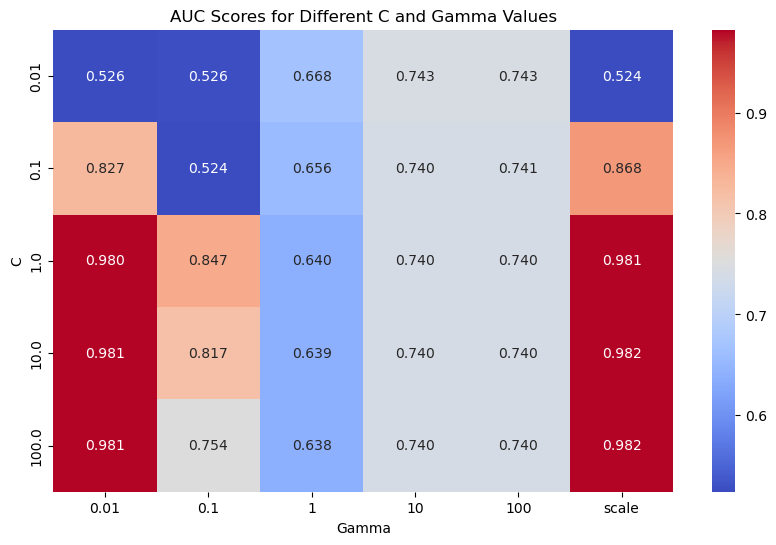

In [19]:
# Convert results to DataFrame
cv_results = pd.DataFrame(grid_search.cv_results_)

# Convert parameters to numeric type for correct sorting
cv_results["param_C"] = cv_results["param_C"].astype(float)
cv_results["param_gamma"] = cv_results["param_gamma"].astype(str)  # Keep gamma as string if 'scale' is used

# Use pivot_table instead of pivot to handle duplicate index-column pairs
df_heatmap = cv_results.pivot_table(index="param_C", columns="param_gamma", values="mean_test_score", aggfunc="mean")

# Sort the index for better visualization
df_heatmap = df_heatmap.sort_index(ascending=True)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_heatmap, annot=True, cmap="coolwarm", fmt=".3f")
plt.title("AUC Scores for Different C and Gamma Values")
plt.xlabel("Gamma")
plt.ylabel("C")
plt.show()



AUC on the test set: 0.9894097222222221

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.62      0.77         8
           1       1.00      0.88      0.93         8
          17       0.88      0.88      0.88         8
          19       0.64      0.88      0.74         8
          21       0.80      1.00      0.89         8
          28       1.00      0.88      0.93         8
          36       0.89      1.00      0.94         8
          37       0.73      1.00      0.84         8
          40       0.75      0.38      0.50         8
          42       1.00      1.00      1.00         8

    accuracy                           0.85        80
   macro avg       0.87      0.85      0.84        80
weighted avg       0.87      0.85      0.84        80


Accuracy on the test set: 0.85


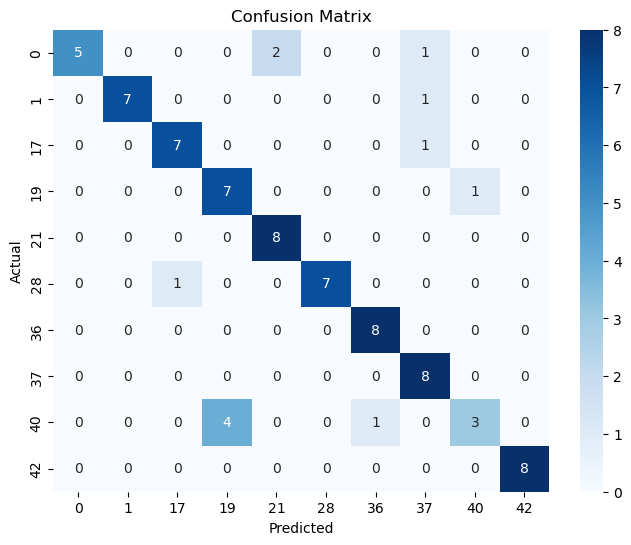

In [20]:
# Initialize the SVM classifier with the best hyperparameters
svm = SVC(kernel='rbf', C=10, gamma='scale', probability=True, random_state=42)

# Train the SVM classifier on the training set
svm.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm.predict(X_test)
y_prob = svm.predict_proba(X_test)

# Evaluate AUC on the test set
test_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
print("\nAUC on the test set:", test_auc)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy on the test set:", accuracy)

# # Calculate TPR and FPR for each class
# tpr_list = []
# fpr_list = []

# print("\nTPR (Recall) and FPR for Each Class:")
# for i in range(len(cm)):  # Iterate over each class
#     tp = cm[i, i]  # True positives for class i
#     fn = sum(cm[i, :]) - tp  # False negatives for class i
#     fp = sum(cm[:, i]) - tp  # False positives for class i
#     tn = cm.sum() - (tp + fn + fp)  # True negatives for class i

#     tpr = tp / (tp + fn) if (tp + fn) != 0 else 0  # Avoid division by zero
#     fpr = fp / (fp + tn) if (fp + tn) != 0 else 0  # Avoid division by zero

#     tpr_list.append(tpr)
#     fpr_list.append(fpr)

#     print(f"Class {i}: TPR (Recall) = {tpr:.2f}, FPR = {fpr:.2f}")

# Visualize the confusion matrix using heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

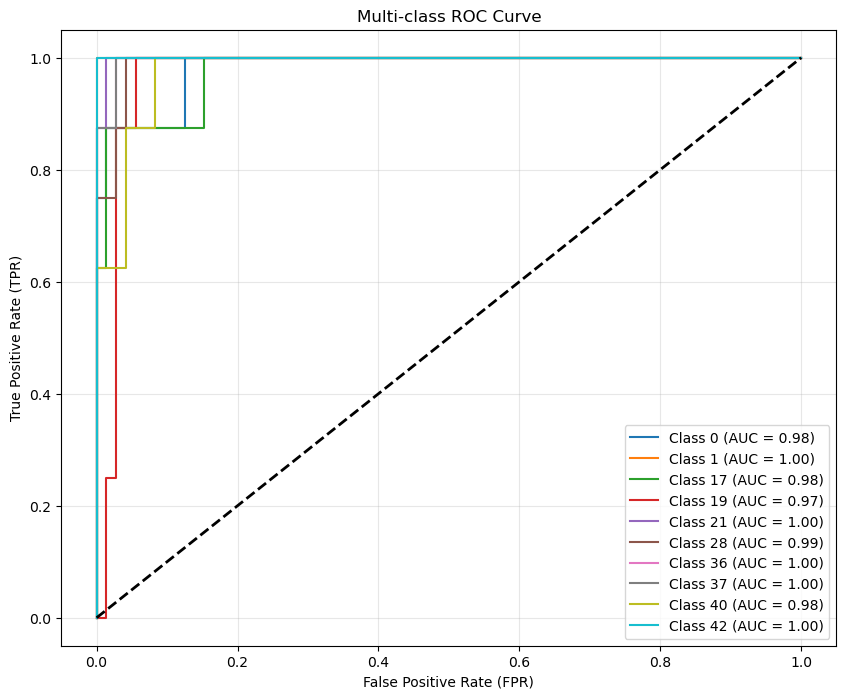

In [21]:
from sklearn.preprocessing import label_binarize

# Binarize the labels for multi-class ROC (One-vs-Rest)
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))

# Initialize a plot
plt.figure(figsize=(10, 8))

# Loop through each class and compute ROC curve and AUC
for i in range(len(np.unique(y_test))):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {np.unique(y_test)[i]} (AUC = {roc_auc:.2f})')

# Plot settings
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line (random classifier)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Multi-class ROC Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

In [22]:
# Reduce features to 30 dimensions using PCA
pca = PCA(n_components=10)  
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)  

print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Reduced feature shape:", X_train_pca.shape)

Explained variance ratio: [0.19509209 0.08515698 0.07228955 0.05691698 0.04521919 0.03602601
 0.03333351 0.03017803 0.02560287 0.02305684]
Reduced feature shape: (320, 10)



AUC on the test set: 0.968923611111111

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.62      0.71         8
           1       1.00      1.00      1.00         8
          17       0.83      0.62      0.71         8
          19       0.56      0.62      0.59         8
          21       0.80      1.00      0.89         8
          28       0.64      0.88      0.74         8
          36       0.88      0.88      0.88         8
          37       1.00      0.88      0.93         8
          40       0.67      0.50      0.57         8
          42       0.89      1.00      0.94         8

    accuracy                           0.80        80
   macro avg       0.81      0.80      0.80        80
weighted avg       0.81      0.80      0.80        80



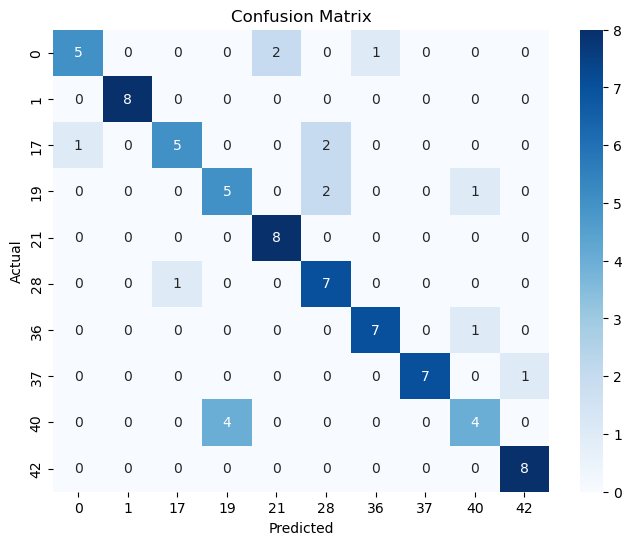

In [23]:
svm = SVC(kernel='rbf', C=10, gamma='scale', probability=True, random_state=42)
svm.fit(X_train_pca, y_train)

# Step 3: Evaluate the classifier
y_pred = svm.predict(X_test_pca)
y_prob = svm.predict_proba(X_test_pca)

# Step 4: Calculate metrics
test_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
print("\nAUC on the test set:", test_auc)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [24]:
# Define feature combinations
feature_combinations = {
    'mfcc': mfcc_features,
    'spectral': spectral_features,
    'hist': hist_features,
    'zcr': zcr_features,
    'envelope': envelope_features,
    'hnr': hnr_features
}

In [25]:
# Run the function and print the top combinations
results = test_feature_combinations_svm(
    combinations_dict=feature_combinations,
    y=y,
    use_gridsearch=False,  # Enable GridSearchCV for hyperparameter tuning
    svm_params={'kernel': 'rbf', 'C': 1, 'gamma': 'scale', 'probability': True, 'random_state': 42},  # Custom SVM parameters
    hyperparameter_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 0.1, 0.01], 'kernel': ['rbf']},  # Custom grid
    overfit_threshold=0.15  # Custom overfitting threshold
)

print("\nTop 5 Feature Combinations (No Overfitting):")
for result in results[:5]:  # Show top 5 combinations without overfitting
    print(f"\nCombination: {result['combination']}, AUC: {result['average_auc']:.4f}, "
          f"Train Acc: {result['average_train_accuracy']:.4f}, Val Acc: {result['average_val_accuracy']:.4f}, "
          f"\nOverfitting: {result['overfitting_status']}, Combined Score: {result['combined_score']:.4f}, "
          f"\nParams: {result['best_params']}")

Tested ('mfcc',): AUC=0.9382, Train Acc=0.8711, Val Acc=0.6719, Overfitting=⚠️ Overfitting Risk
Tested ('spectral',): AUC=0.9728, Train Acc=0.8742, Val Acc=0.7469, Overfitting=✅ No Overfitting
Tested ('hist',): AUC=0.8679, Train Acc=0.5875, Val Acc=0.4625, Overfitting=✅ No Overfitting
Tested ('zcr',): AUC=0.8593, Train Acc=0.4625, Val Acc=0.3906, Overfitting=✅ No Overfitting
Tested ('envelope',): AUC=0.8678, Train Acc=0.5172, Val Acc=0.4344, Overfitting=✅ No Overfitting
Tested ('hnr',): AUC=0.7175, Train Acc=0.1938, Val Acc=0.1625, Overfitting=✅ No Overfitting
Tested ('mfcc', 'spectral'): AUC=0.9745, Train Acc=0.9125, Val Acc=0.7625, Overfitting=⚠️ Overfitting Risk
Tested ('mfcc', 'hist'): AUC=0.9177, Train Acc=0.6852, Val Acc=0.5875, Overfitting=✅ No Overfitting
Tested ('mfcc', 'zcr'): AUC=0.9477, Train Acc=0.8852, Val Acc=0.7000, Overfitting=⚠️ Overfitting Risk
Tested ('mfcc', 'envelope'): AUC=0.9483, Train Acc=0.8703, Val Acc=0.6781, Overfitting=⚠️ Overfitting Risk
Tested ('mfcc', '

In [26]:
top_5_results_length_lim = [res for res in results if len(res['combination']) == 3 and res['overfitting_status'] == "✅ No Overfitting"]
top_5_results_length_lim.sort(key=lambda x: x['combined_score'], reverse=True)

print("\nTop 5 Non-Overfitted Combinations with Exactly 3 Features:")
for res in top_5_results_length_lim[:5]:  # Display the top 5
    print(f"Combination: {res['combination']}, AUC: {res['average_auc']:.4f}, "
          f"Val Accuracy: {res['average_val_accuracy']:.4f}, Overfitting: {res['overfitting_status']}")


Top 5 Non-Overfitted Combinations with Exactly 3 Features:
Combination: ('mfcc', 'spectral', 'envelope'), AUC: 0.9801, Val Accuracy: 0.8000, Overfitting: ✅ No Overfitting
Combination: ('mfcc', 'spectral', 'zcr'), AUC: 0.9758, Val Accuracy: 0.7750, Overfitting: ✅ No Overfitting
Combination: ('spectral', 'zcr', 'envelope'), AUC: 0.9768, Val Accuracy: 0.7719, Overfitting: ✅ No Overfitting
Combination: ('mfcc', 'spectral', 'hnr'), AUC: 0.9747, Val Accuracy: 0.7688, Overfitting: ✅ No Overfitting
Combination: ('spectral', 'envelope', 'hnr'), AUC: 0.9742, Val Accuracy: 0.7656, Overfitting: ✅ No Overfitting


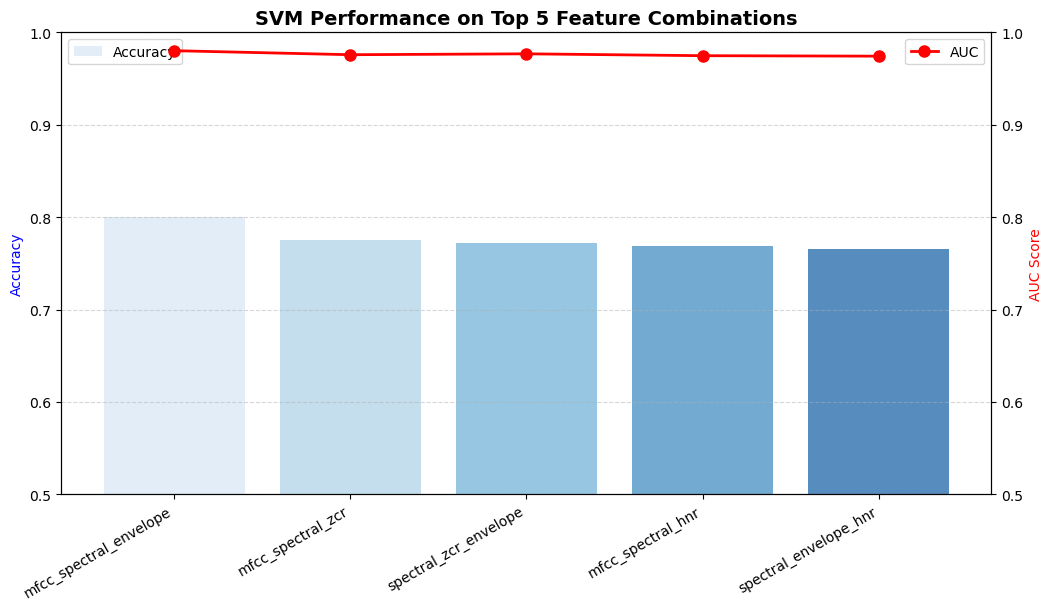

In [27]:
# Extract information from top 5 non-overfitted results
feature_names = ["_".join(res['combination']) for res in top_5_results_length_lim[:5]]
accuracies = [res['average_val_accuracy'] for res in top_5_results_length_lim[:5]]
auc_scores = [res['average_auc'] for res in top_5_results_length_lim[:5]]

# Create the figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Use different colors for bars
colors = sns.color_palette("Blues", len(feature_names))

# Plot Accuracy (Bar chart)
ax1.bar(feature_names, accuracies, color=colors, alpha=0.7, label='Accuracy')
ax1.set_ylabel('Accuracy', color='b')
ax1.set_ylim(0.5, 1.0)  # Set limits to fit the data well

# Rotate X-axis labels for better readability
plt.xticks(rotation=30, ha="right", fontsize=10)

# Add grid lines for better visual separation
ax1.grid(axis='y', linestyle='--', alpha=0.5)

# Create a second y-axis for AUC scores
ax2 = ax1.twinx()

# Plot AUC as a red line with markers
ax2.plot(feature_names, auc_scores, color='r', marker='o', linestyle='-', linewidth=2, markersize=8, label='AUC')
ax2.set_ylabel('AUC Score', color='r')
ax2.set_ylim(0.5, 1.0)  # Set limits to fit the data well

# Formatting
plt.title("SVM Performance on Top 5 Feature Combinations", fontsize=14, fontweight='bold')

# Add legends
ax1.legend(loc='upper left', fontsize=10)
ax2.legend(loc='upper right', fontsize=10)

# Show the plot
plt.show()

In [28]:
# Load saved features
loaded_data = np.load("features/extracted_features_multiple_test.npz")

# Define which features to include (set True to include, False to exclude)
feature_selection = {
    'mfcc': True,
    'hist': False,
    'spectral': True,
    'zcr': True,
    'envelope': True,
    'hnr': True
}

# Display the shapes of each feature type
print("Feature shapes and selection status:")
for feature, include in feature_selection.items():
    shape = loaded_data[feature].shape
    status = "✅" if include else "❌"
    print(f"{feature.capitalize()} shape: {shape} - Status: {status}")

# Extract features and labels
keys_list = loaded_data['keys']
mfcc_features = loaded_data['mfcc']
hist_features = loaded_data['hist']
spectral_features = loaded_data['spectral']
zcr_features = loaded_data['zcr']
envelope_features = loaded_data['envelope']
hnr_features = loaded_data['hnr']

# Combine features based on flags
combined_features = combine_features_with_flags(loaded_data, feature_selection)
print("\nCombined features shape:", combined_features.shape)

# Train-Test Splitting
X = combined_features
y = np.array(keys_list)

# Train-test split
X_train_not_scaled, X_test_not_scaled, y_train, y_test = train_test_split(
    combined_features, np.array(keys_list), test_size=0.2, random_state=42, stratify=keys_list
)

# Normalize the data using Z-score normalization (StandardScaler)
scaler = StandardScaler()

# Fit only on the training data and transform both train and test sets
X_train = scaler.fit_transform(X_train_not_scaled)  # Fit on train data only
X_test = scaler.transform(X_test_not_scaled)        # Use train's mean and std to scale test data



Feature shapes and selection status:
Mfcc shape: (400, 26) - Status: ✅
Hist shape: (400, 80) - Status: ❌
Spectral shape: (400, 20) - Status: ✅
Zcr shape: (400, 2) - Status: ✅
Envelope shape: (400, 5) - Status: ✅
Hnr shape: (400, 1) - Status: ✅

Combined features shape: (400, 54)


In [29]:
# # Reduce features to  dimensions using PCA
# pca = PCA(n_components=20)  
# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)  

# print("Explained variance ratio:", pca.explained_variance_ratio_)
# print("Reduced feature shape:", X_train.shape)

In [30]:
# Custom AUC scorer for multi-class (One-vs-Rest)
auc_scorer = make_scorer(roc_auc_score, multi_class='ovr', response_method='predict_proba')

# Initialize Stratified K-Fold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 1, 'scale', 10, 100],
    'kernel': ['rbf']
}

# Perform GridSearchCV with the custom AUC scorer
grid_search = GridSearchCV(
    SVC(probability=True),
    param_grid=param_grid,
    scoring=auc_scorer,
    cv=kfold,
    verbose=2,
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and mean AUC during cross-validation
print("\nBest hyperparameters:", grid_search.best_params_)
print("Best mean AUC during cross-validation:", grid_search.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best hyperparameters: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
Best mean AUC during cross-validation: 0.9859108979344914



AUC on the test set: 0.9831597222222224

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       1.00      0.75      0.86         8
          17       0.86      0.75      0.80         8
          19       0.70      0.88      0.78         8
          21       0.67      1.00      0.80         8
          28       0.75      0.75      0.75         8
          36       1.00      1.00      1.00         8
          37       0.80      1.00      0.89         8
          40       1.00      0.62      0.77         8
          42       1.00      1.00      1.00         8

    accuracy                           0.85        80
   macro avg       0.88      0.85      0.85        80
weighted avg       0.88      0.85      0.85        80


Accuracy on the test set: 0.85
Training Accuracy: 0.94375


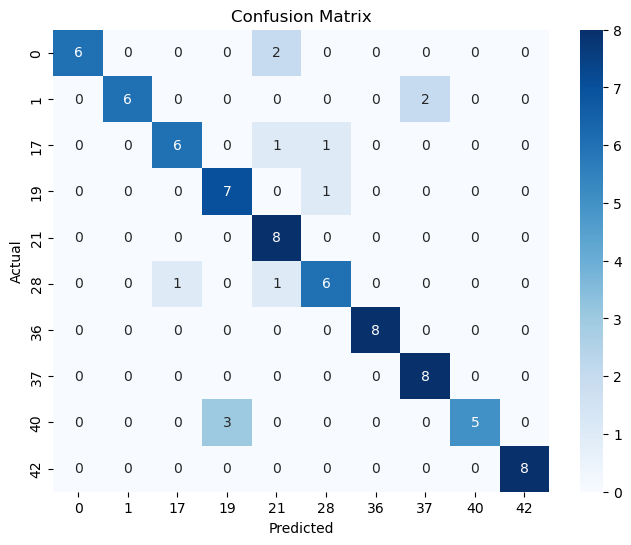

In [31]:
# Initialize the SVM classifier with the best hyperparameters
svm = SVC(kernel='rbf', C=1, gamma=0.01, probability=True, random_state=42)

# Train the SVM classifier on the training set
svm.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm.predict(X_test)
y_prob = svm.predict_proba(X_test)

# Evaluate AUC on the test set
test_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
print("\nAUC on the test set:", test_auc)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy on the test set:", accuracy)

train_accuracy = svm.score(X_train, y_train)
print("Training Accuracy:", train_accuracy)

# Visualize the confusion matrix using heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [144]:
# Load saved features
loaded_data = np.load("features/extracted_features_multiple_test.npz")

# Define which features to include (set True to include, False to exclude)
feature_selection = {
    'mfcc': True,
    'hist': True,
    'spectral': True,
    'zcr': True,
    'envelope': True,
    'hnr': True
}

# Display the shapes of each feature type
print("Feature shapes and selection status:")
for feature, include in feature_selection.items():
    shape = loaded_data[feature].shape
    status = "✅" if include else "❌"
    print(f"{feature.capitalize()} shape: {shape} - Status: {status}")

# Extract features and labels
keys_list = loaded_data['keys']
mfcc_features = loaded_data['mfcc']
hist_features = loaded_data['hist']
spectral_features = loaded_data['spectral']
zcr_features = loaded_data['zcr']
envelope_features = loaded_data['envelope']
hnr_features = loaded_data['hnr']

# Combine features based on flags
combined_features = combine_features_with_flags(loaded_data, feature_selection)
print("\nCombined features shape:", combined_features.shape)

# Train-Test Splitting
X = combined_features
y = np.array(keys_list)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    combined_features, np.array(keys_list), test_size=0.2, random_state=42, stratify=keys_list
)


Feature shapes and selection status:
Mfcc shape: (400, 26) - Status: ✅
Hist shape: (400, 80) - Status: ✅
Spectral shape: (400, 20) - Status: ✅
Zcr shape: (400, 2) - Status: ✅
Envelope shape: (400, 5) - Status: ✅
Hnr shape: (400, 1) - Status: ✅

Combined features shape: (400, 134)


In [33]:
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)

# rf.fit(X_train, y_train)
# y_pred_rf = rf.predict(X_test)
# train_accuracy = accuracy_score(y_train, rf.predict(X_train))
# test_accuracy = accuracy_score(y_test, y_pred_rf)

# print("\nTraining Accuracy:", train_accuracy)
# print("\nTest Accuracy:", test_accuracy)


Random Forest - AUC on the test set: 0.9498263888888889

Random Forest - Accuracy on the test set: 0.725

Training Accuracy: 0.96875

Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.75      0.80         8
           1       0.78      0.88      0.82         8
          17       0.86      0.75      0.80         8
          19       0.56      0.62      0.59         8
          21       0.80      1.00      0.89         8
          28       0.44      0.50      0.47         8
          36       1.00      0.75      0.86         8
          37       0.64      0.88      0.74         8
          40       1.00      0.50      0.67         8
          42       0.62      0.62      0.62         8

    accuracy                           0.72        80
   macro avg       0.76      0.72      0.73        80
weighted avg       0.76      0.72      0.73        80



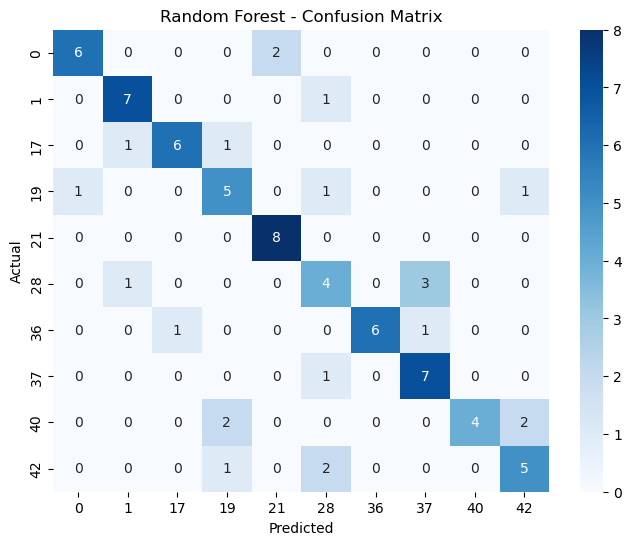

In [34]:
# AUC score
test_auc_rf = roc_auc_score(y_test, y_prob_rf, multi_class='ovr')

# Accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)

# Classification report
print("\nRandom Forest - AUC on the test set:", test_auc_rf)
print("\nRandom Forest - Accuracy on the test set:", accuracy_rf)
y_train_pred = rf.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("\nTraining Accuracy:", train_accuracy)
print("\nRandom Forest - Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Confusion matrix visualization
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest - Confusion Matrix')
plt.show()

In [35]:
y_train_pred = rf.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

print("\nTraining Accuracy:", train_accuracy)


Training Accuracy: 0.96875


In [105]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='roc_auc_ovr', n_jobs=-1, verbose=1)
grid_search_rf.fit(X_train, y_train)
print("\nBest Parameters for Random Forest:", grid_search_rf.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best Parameters for Random Forest: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}


In [111]:
rf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=10, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)


Random Forest - AUC on the test set: 0.9928819444444444

Random Forest - Accuracy on the test set: 0.9125

Training Accuracy: 1.0

Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       0.89      1.00      0.94         8
          17       0.75      0.75      0.75         8
          19       0.80      1.00      0.89         8
          21       1.00      1.00      1.00         8
          28       1.00      0.75      0.86         8
          36       0.89      1.00      0.94         8
          37       1.00      1.00      1.00         8
          40       1.00      0.75      0.86         8
          42       1.00      0.88      0.93         8

    accuracy                           0.91        80
   macro avg       0.92      0.91      0.91        80
weighted avg       0.92      0.91      0.91        80



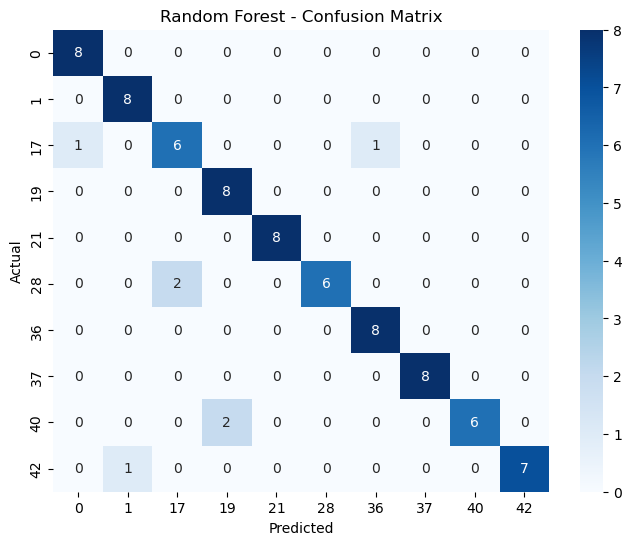

In [113]:
test_auc_rf = roc_auc_score(y_test, y_prob_rf, multi_class='ovr')
accuracy_rf = accuracy_score(y_test, y_pred_rf)

# Classification report
print("\nRandom Forest - AUC on the test set:", test_auc_rf)
print("\nRandom Forest - Accuracy on the test set:", accuracy_rf)
y_train_pred = rf.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("\nTraining Accuracy:", train_accuracy)
print("\nRandom Forest - Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Confusion matrix visualization
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest - Confusion Matrix')
plt.show()

In [154]:
rf_results = test_feature_combinations_rf(
    combinations_dict=feature_combinations,  # Your feature dictionary
    y=y,  # Your corresponding labels
    use_gridsearch=False,  # Enable GridSearchCV for hyperparameter tuning
    rf_params={  # Default RF parameters
        'n_estimators': 100,
        'max_depth': 10,
        'min_samples_split': 5,
        'random_state': 42
    },    
    n_splits=5,  # Number of Stratified K-Folds
    n_pca_components=10,  # Number of PCA components to apply if needed
    normalize=False,  # Enable normalization of features
    apply_pca=False,  # Disable PCA here for testing; set to True if needed
    overfit_threshold=0.3,  # Threshold to detect overfitting
    hyperparameter_grid=None
    # hyperparameter_grid={
    #     'n_estimators': [50, 100, 150],  # RF hyperparameters for GridSearchCV
    #     'max_depth': [None, 10, 20],
    #     'min_samples_split': [2, 5, 10]
    # }
)

# Display top results
print("\nTop 5 Non-Overfitted Combinations:")
for result in rf_results[:5]:  # Display the top 5 combinations
    print(f"Combination: {result['combination']}, AUC: {result['average_auc']:.4f}, "
          f"Train Acc: {result['average_train_accuracy']:.4f}, Val Acc: {result['average_val_accuracy']:.4f}, "
          f"Overfitting: {result['overfitting_status']}, Combined Score: {result['combined_score']:.4f}")

Tested ('mfcc',): AUC=0.9595, Train Acc=0.9984, Val Acc=0.7312, Overfitting=✅ No Overfitting
Tested ('spectral',): AUC=0.9717, Train Acc=0.9992, Val Acc=0.7656, Overfitting=✅ No Overfitting
Tested ('hist',): AUC=0.9156, Train Acc=0.9977, Val Acc=0.5906, Overfitting=⚠️ Overfitting Risk
Tested ('zcr',): AUC=0.8702, Train Acc=0.9266, Val Acc=0.4625, Overfitting=⚠️ Overfitting Risk
Tested ('envelope',): AUC=0.8665, Train Acc=0.9602, Val Acc=0.4906, Overfitting=⚠️ Overfitting Risk
Tested ('hnr',): AUC=0.7360, Train Acc=0.7547, Val Acc=0.2500, Overfitting=⚠️ Overfitting Risk
Tested ('mfcc', 'spectral'): AUC=0.9840, Train Acc=1.0000, Val Acc=0.8344, Overfitting=⚠️ Overfitting Risk
Tested ('mfcc', 'hist'): AUC=0.9693, Train Acc=1.0000, Val Acc=0.7844, Overfitting=⚠️ Overfitting Risk
Tested ('mfcc', 'zcr'): AUC=0.9683, Train Acc=0.9992, Val Acc=0.7562, Overfitting=✅ No Overfitting
Tested ('mfcc', 'envelope'): AUC=0.9687, Train Acc=1.0000, Val Acc=0.7562, Overfitting=⚠️ Overfitting Risk
Tested (

In [148]:
# Load saved features
loaded_data = np.load("features/extracted_features_multiple_test.npz")

# Define which features to include (set True to include, False to exclude)
feature_selection = {
    'mfcc': False,
    'hist': False,
    'spectral': True,
    'zcr': False,
    'envelope': False,
    'hnr': False
}

# Display the shapes of each feature type
print("Feature shapes and selection status:")
for feature, include in feature_selection.items():
    shape = loaded_data[feature].shape
    status = "✅" if include else "❌"
    print(f"{feature.capitalize()} shape: {shape} - Status: {status}")

# Extract features and labels
keys_list = loaded_data['keys']
mfcc_features = loaded_data['mfcc']
hist_features = loaded_data['hist']
spectral_features = loaded_data['spectral']
zcr_features = loaded_data['zcr']
envelope_features = loaded_data['envelope']
hnr_features = loaded_data['hnr']

# Combine features based on flags
combined_features = combine_features_with_flags(loaded_data, feature_selection)
print("\nCombined features shape:", combined_features.shape)

# Train-Test Splitting
X = combined_features
y = np.array(keys_list)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    combined_features, np.array(keys_list), test_size=0.2, random_state=42, stratify=keys_list
)


Feature shapes and selection status:
Mfcc shape: (400, 26) - Status: ❌
Hist shape: (400, 80) - Status: ❌
Spectral shape: (400, 20) - Status: ✅
Zcr shape: (400, 2) - Status: ❌
Envelope shape: (400, 5) - Status: ❌
Hnr shape: (400, 1) - Status: ❌

Combined features shape: (400, 20)


In [118]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='roc_auc_ovr', n_jobs=-1, verbose=1)
grid_search_rf.fit(X_train, y_train)
print("\nBest Parameters for Random Forest:", grid_search_rf.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best Parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


In [150]:
rf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)


Random Forest - AUC on the test set: 0.9894097222222221

Random Forest - Accuracy on the test set: 0.875

Training Accuracy: 1.0

Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.73      1.00      0.84         8
          17       0.88      0.88      0.88         8
          19       0.73      1.00      0.84         8
          21       0.78      0.88      0.82         8
          28       0.89      1.00      0.94         8
          36       1.00      0.88      0.93         8
          37       1.00      0.75      0.86         8
          40       1.00      0.62      0.77         8
          42       1.00      0.88      0.93         8

    accuracy                           0.88        80
   macro avg       0.90      0.88      0.88        80
weighted avg       0.90      0.88      0.88        80



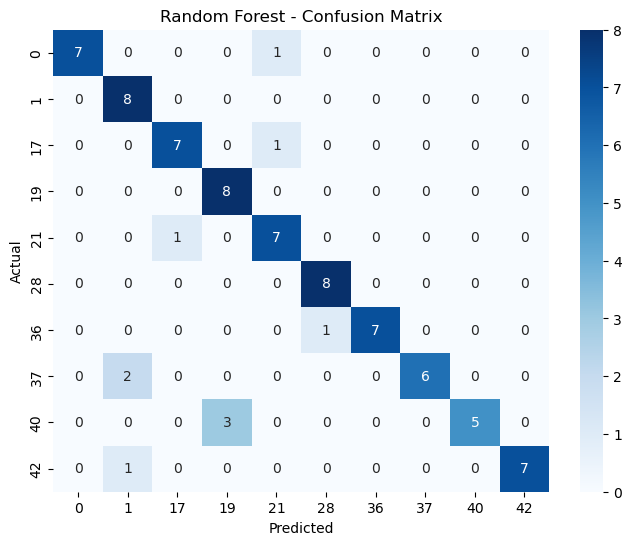

In [152]:
test_auc_rf = roc_auc_score(y_test, y_prob_rf, multi_class='ovr')
accuracy_rf = accuracy_score(y_test, y_pred_rf)

# Classification report
print("\nRandom Forest - AUC on the test set:", test_auc_rf)
print("\nRandom Forest - Accuracy on the test set:", accuracy_rf)
y_train_pred = rf.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("\nTraining Accuracy:", train_accuracy)
print("\nRandom Forest - Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Confusion matrix visualization
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest - Confusion Matrix')
plt.show()

In [158]:
# Manually test the top combination ('spectral',) using K-Fold Cross-Validation
top_combination = ['spectral']
selected_features = np.hstack([feature_combinations[feat] for feat in top_combination])

# Set up K-Fold Cross-Validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_accuracies = []
test_accuracies = []
auc_scores = []

# Loop through each fold
for train_idx, test_idx in kfold.split(selected_features, y):
    X_train, X_test = selected_features[train_idx], selected_features[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Train the RF classifier
    rf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, random_state=42)
    rf.fit(X_train, y_train)

    # Evaluate on training set
    y_train_pred = rf.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_accuracies.append(train_accuracy)

    # Evaluate on test set
    y_test_pred = rf.predict(X_test)
    y_test_prob = rf.predict_proba(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_accuracies.append(test_accuracy)

    # Compute AUC score
    auc = roc_auc_score(y_test, y_test_prob, multi_class='ovr')
    auc_scores.append(auc)

# Calculate average metrics
avg_train_accuracy = np.mean(train_accuracies)
avg_test_accuracy = np.mean(test_accuracies)
avg_auc = np.mean(auc_scores)

print(f"\nK-Fold Cross-Validation with Combination {top_combination}")
print(f"Average Train Accuracy: {avg_train_accuracy:.4f}")
print(f"Average Test Accuracy: {avg_test_accuracy:.4f}")
print(f"Average AUC: {avg_auc:.4f}")

# Overfitting detection
overfitting_gap = avg_train_accuracy - avg_test_accuracy
overfitting_status = "⚠️ Overfitting Risk" if avg_train_accuracy == 1.0 or overfitting_gap > 0.1 else "✅ No Overfitting"
print(f"Overfitting Status: {overfitting_status} (Train-Test Gap: {overfitting_gap:.4f})")


K-Fold Cross-Validation with Combination ['spectral']
Average Train Accuracy: 0.9994
Average Test Accuracy: 0.7800
Average AUC: 0.9779
Overfitting Status: ⚠️ Overfitting Risk (Train-Test Gap: 0.2194)
